In [2]:
#install libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tueplots

import sys
print(sys.executable)

/Users/madelinemiller/Desktop/data_literacy/geonews_femicide/source/.venv/bin/python


In [14]:
#set source and output paths
source_path = '../../data/'
csv_output_path = '../../data/processed/'
figure_output_path = '../../paper/figures/'

#upload raw query data
df_32_raw = pd.read_csv(f'{source_path}repository_queries/500000_32_homicide-female_DE.csv') 
#upload manually tagged articles with json data
df_tag = pd.read_csv(f'{source_path}processed/manual-tag_all_parsedson.csv')
#filter to only ones with T/F data
df_tag_valid = df_tag.dropna(subset=['woman_murdered'])
#upload keyword data
df_key = pd.read_csv(f'{source_path}manual_tag/femicide_keywords.csv')
#upload top 50 data
df_50 = pd.read_csv(f'{source_path}processed/7-9_22_24_26-27_31-32_2017-2023_top50.csv')

#filter to only one entry per NUTS
df_32_raw['NUTS'] = df_32_raw['NUTS'].fillna('').astype(str)
df_32 = df_32_raw.groupby('id').agg({
    'NUTS': lambda x: ', '.join(sorted(set(code for code in x if code.startswith('DE')))),
    'url': 'first',
    'hostname': 'first',
    'date': 'first',
    'cos_dist': 'first' # these values will all be the same
    }).reset_index()

In [27]:
#For each query, how many of top 50 are relevant versus not relevant?

#join tagging information to top 50, remove articles that don't have T/F data (inner join)
df_50_tag= df_50.merge(df_tag_valid[['id', 'woman_murdered']], on='id', how='inner')
print(f"shape df_50: {df_50.shape}")
print(f"shape df_50_tag: {df_50_tag.shape}")

#get list of queries
queries = [col.removeprefix('cos_rank_') for col in df_50_tag.columns if col.startswith('cos_rank_')]
query_dict = {} #empty query dictionary

#for each query:
# Build query_dict with relevant/irrelevant article ranks per query
for query in queries:
    rank_col = f'cos_rank_{query}'
    
    # Get ranks for relevant articles (woman_murdered == True)
    relevant_ranks = df_50_tag[df_50_tag['woman_murdered'] == True][rank_col].values
    
    # Get ranks for irrelevant articles (woman_murdered == False)
    irrelevant_ranks = df_50_tag[df_50_tag['woman_murdered'] == False][rank_col].values
    
    query_dict[query] = {
        'relevant': relevant_ranks,
        'irrelevant': irrelevant_ranks
    }

# Check the structure
for query in queries[:2]:  # Show first 2 queries
    print(f"\nQuery: {query}")
    print(f"  Relevant articles: {len(query_dict[query]['relevant'])}")
    print(f"  Irrelevant articles: {len(query_dict[query]['irrelevant'])}")
    print(f"  Sample relevant ranks: {query_dict[query]['relevant'][:5]}")
#how many relevant articles in top 50? How many irrelevant in top 50?

shape df_50: (306, 24)
shape df_50_tag: (256, 25)

Query: 7_police-report-gender-motivated_EN
  Relevant articles: 187
  Irrelevant articles: 69
  Sample relevant ranks: [1. 2. 3. 4. 5.]

Query: 8_police-report-gender-motivated_DE
  Relevant articles: 187
  Irrelevant articles: 69
  Sample relevant ranks: [5325.  314.  407.  419.  579.]


In [97]:
def make_rank_plot_subplots(query_data):
    queries = list(query_data.keys())
    n_queries = len(queries)
    
    fig, axes = plt.subplots(n_queries, 1, figsize=(12, n_queries * 1.2), 
                             sharex=True, sharey=False)
    
    if n_queries == 1:
        axes = [axes]
    
    Nmax = max(max(len(query_data[q]['relevant']), len(query_data[q]['irrelevant'])) 
               for q in queries)
    np.random.seed(1)
    u = np.random.rand(Nmax)
    
    for i, query in enumerate(queries):
        ax = axes[i]
        relevant_ranks = query_data[query]['relevant']
        irrelevant_ranks = query_data[query]['irrelevant']
        n_rel = len(relevant_ranks)
        n_irrel = len(irrelevant_ranks)
        
        # Plot both on same subplot
        ax.plot(relevant_ranks, 0.4 * u[:n_rel] + 0.4,
                'o', alpha=0.7, color='orange', ms=4, mec='none', label='Relevant')
        ax.plot(irrelevant_ranks, 0.4 * u[:n_irrel] - 0.4,
                'o', alpha=0.7, color='blue', ms=4, mec='none', label='Irrelevant')
        
        ax.set_ylabel(query, fontsize=9, rotation=0, ha='right', va='center')
        ax.set_ylim(-1, 1)
        ax.set_yticks([])
        ax.grid(axis='x', alpha=0.3)
        ax.set_xlim(0, 100)
        ax.legend(loc='upper right', fontsize=8)
        ax.text(0.02, 0.98, f"R:{n_rel} | I:{n_irrel}", 
               transform=ax.transAxes, va='top', fontsize=8, color='gray')
        ax.axvline(50, color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    axes[-1].set_xlabel("Rank", fontsize=12)
    fig.suptitle("Article Ranks by Query and Relevance", fontsize=14, y=0.995)
    plt.tight_layout()
    return fig, axes, u

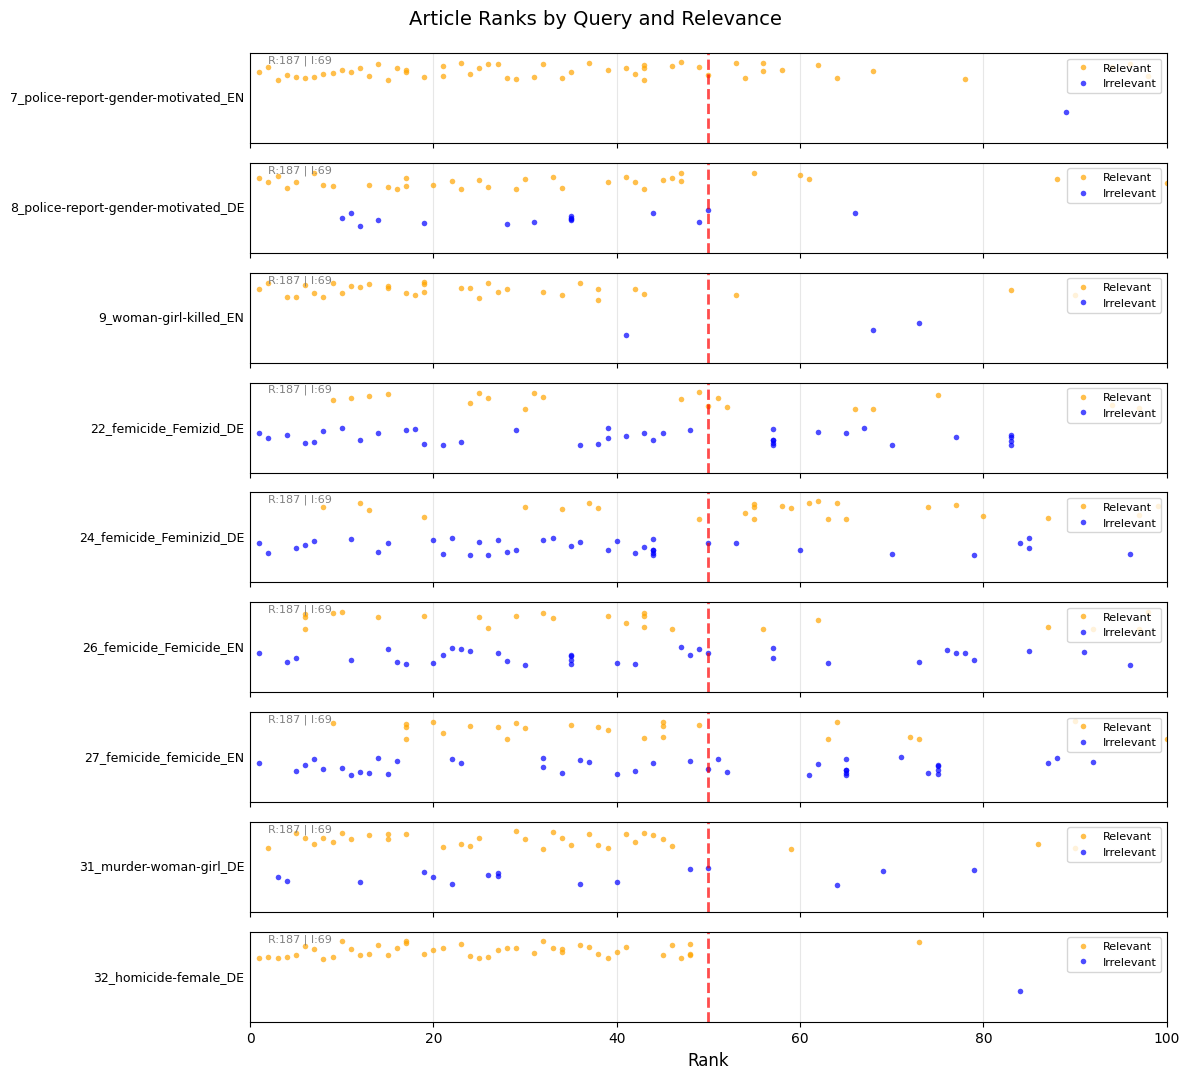

In [99]:
fig, ax, _ = make_rank_plot_subplots(query_dict)
fig.savefig(f"{figure_output_path}query-subplots_compare.pdf")

In [112]:
# Assuming Q32 is '32_homicide-female_DE' or similar
q32_column = 'cos_rank_32_homicide-female_DE'  # adjust to your actual column name
threshold = 0.24

# Get IDs of articles excluded from Q32 (cosine similarity < threshold)
# You'll need the cosine similarity column, not rank
q32_excluded_ids = df_50_tag[df_50_tag['cos_dist_32_homicide-female_DE'] > threshold]['id'].values

In [113]:
def make_rank_plot(query_data, q32_excluded_ids=None, df_50_tag=None):
    queries = list(query_data.keys())
    
    fig, ax = plt.subplots(figsize=(12, len(queries) * 0.8))
    
    for i, query in enumerate(queries):
        y_pos = i
        rank_col = f'cos_rank_{query}'
        
        if q32_excluded_ids is not None and df_50_tag is not None:
            # Split into 4 categories
            relevant_mask = df_50_tag['woman_murdered'] == True
            excluded_mask = df_50_tag['id'].isin(q32_excluded_ids)
            
            # Relevant & included in Q32 (orange circles)
            rel_incl = df_50_tag[relevant_mask & ~excluded_mask][rank_col].values
            # Relevant & excluded from Q32 (orange squares with black outline)
            rel_excl = df_50_tag[relevant_mask & excluded_mask][rank_col].values
            # Irrelevant & included in Q32 (blue circles)
            irrel_incl = df_50_tag[~relevant_mask & ~excluded_mask][rank_col].values
            # Irrelevant & excluded from Q32 (blue squares with black outline)
            irrel_excl = df_50_tag[~relevant_mask & excluded_mask][rank_col].values
            
            # Plot circles for Q32-included
            ax.plot(rel_incl, [y_pos] * len(rel_incl),
                    'o', alpha=0.7, color='orange', ms=4, mec='none', 
                    label=f'Relevant (Q32 included threshold {threshold})' if i == 0 else '')
            ax.plot(irrel_incl, [y_pos] * len(irrel_incl),
                    'o', alpha=0.7, color='blue', ms=4, mec='none', 
                    label=f'Irrelevant (Q32 included threshold {threshold})' if i == 0 else '')
            
            # Plot squares for Q32-excluded
            ax.plot(rel_excl, [y_pos] * len(rel_excl),
                    's', alpha=0.7, color='orange', ms=6, mec='black', mew=1.5,
                    label='Relevant (Q32 excluded)' if i == 0 else '')
            ax.plot(irrel_excl, [y_pos] * len(irrel_excl),
                    's', alpha=0.7, color='blue', ms=6, mec='black', mew=1.5,
                    label='Irrelevant (Q32 excluded)' if i == 0 else '')
        else:
            # Fallback to original 2 categories
            relevant_ranks = query_data[query]['relevant']
            irrelevant_ranks = query_data[query]['irrelevant']
            
            ax.plot(relevant_ranks, [y_pos] * len(relevant_ranks),
                    'o', alpha=0.7, color='orange', ms=4, mec='none', 
                    label='Relevant' if i == 0 else '')
            ax.plot(irrelevant_ranks, [y_pos] * len(irrelevant_ranks),
                    'o', alpha=0.7, color='blue', ms=4, mec='none', 
                    label='Irrelevant' if i == 0 else '')
    
    # Set y-axis labels
    ax.set_yticks(range(len(queries)))
    ax.set_yticklabels(queries)
    
    # Add separator lines and counts
    for i, query in enumerate(queries):
        if i > 0:
            ax.axhline(i - 0.5, color='gray', alpha=0.3, linewidth=0.5)
    
    ax.set_xlabel("Rank", fontsize=12)
    ax.set_xlim(0, 100)
    ax.set_ylim(-0.5, len(queries) - 0.5)
    ax.axvline(50, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.axvline(25, color='red', linestyle='--', linewidth=1, alpha=0.7)
    ax.grid(axis='x', alpha=0.3)
    ax.legend(loc='upper right', fontsize=9)
    ax.set_title(f"Article Ranks by Query and Relevance, Q32 Threshold {threshold}", fontsize=14, pad=20)
    
    plt.tight_layout()
    return fig, ax

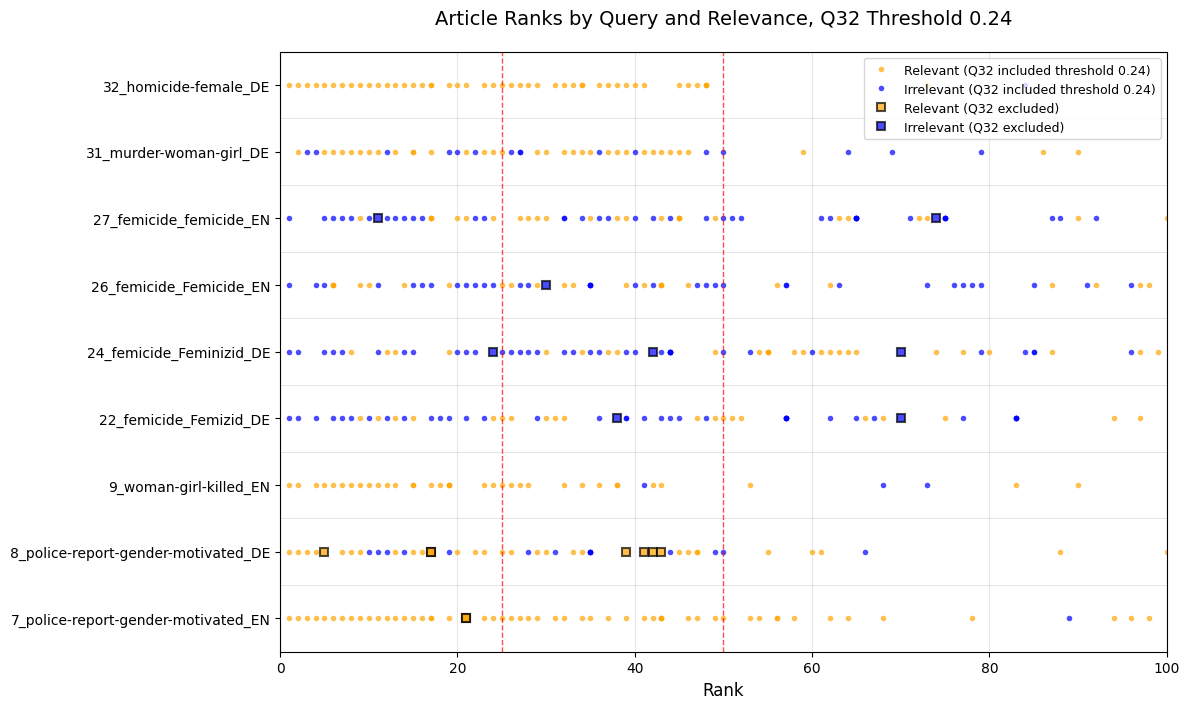

In [114]:
fig, ax = make_rank_plot(query_dict, q32_excluded_ids=q32_excluded_ids, df_50_tag=df_50_tag)
fig.savefig(f"{figure_output_path}query-subplots_compare_q32threshold24.pdf")

In [ ]:
#Which false do not show up in Q32?
#Which false do not show up in Q32 that are above threshold?

#Which true do not show up in Q32?
#Which true do not show up in Q32 below threshold?

In [ ]:
#visualize: True/False of top 50 for queries
#highlighting ones that don't appear in 